In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import scipy.stats as stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [1]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# **Splice-junction Gene Sequences (High-Dimensional Data)**

In [7]:
dna_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Datasets2\MolecularBiology\dna.csv')

In [8]:
dna_df.head()

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A171,A172,A173,A174,A175,A176,A177,A178,A179,class
0,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,1,0,0,3
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,3
2,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,3
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,1
4,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,2


In [12]:
dna_df.shape

(3186, 181)

In [11]:
X = dna_df.iloc[:, 0:-1]
y = dna_df.iloc[:, -1]

In [15]:
le = LabelEncoder()
y = le.fit_transform(y)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

100%|██████████| 50/50 [05:17<00:00,  6.35s/trial, best loss: -0.9733542319749217]
Best hyperparameters for AdaBoost:
{'n_estimators': 1450.0, 'learning_rate': 0.010021975389469587, 'max_depth': 6.0, 'max_features': 'sqrt', 'min_samples_leaf': 5.0, 'min_samples_split': 4.0, 'random_state': 42}
100%|██████████| 50/50 [08:34<00:00, 10.30s/trial, best loss: -0.9592476489028213]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': None, 'n_estimators': 850, 'learning_rate': 0.053611707225416305, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 0.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [14:51<00:00, 17.83s/trial, best loss: -0.9639498432601881]
Best hyperparameters for CatBoost:
{'n_estimators': 550, 'learning_rate': 0.0479901225935416, 'min_child_samples': 1, 'max_depth': 6, 'reg_lambda': 3.3766279624518107, 'silent': True, 'random_state': 42}
100%|██████████| 50/5

In [22]:
best_hyperparams['AdaBoost']

{'n_estimators': 1450.0,
 'learning_rate': 0.010021975389469587,
 'max_depth': 6.0,
 'max_features': 'sqrt',
 'min_samples_leaf': 5.0,
 'min_samples_split': 4.0,
 'random_state': 42}

In [23]:
best_hyperparams['GradBoost']

{'criterion': 'friedman_mse',
 'max_features': None,
 'n_estimators': 850,
 'learning_rate': 0.053611707225416305,
 'max_depth': 3,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'min_weight_fraction_leaf': 0.1,
 'min_impurity_decrease': 0.0,
 'ccp_alpha': 0.0,
 'random_state': 42}

In [24]:
best_hyperparams['CatBoost']

{'n_estimators': 550,
 'learning_rate': 0.0479901225935416,
 'min_child_samples': 1,
 'max_depth': 6,
 'reg_lambda': 3.3766279624518107,
 'silent': True,
 'random_state': 42}

In [25]:
best_hyperparams['LightGBM']

{'class_weight': 'balanced',
 'boosting_type': 'gbdt',
 'num_leaves': 55,
 'learning_rate': 0.09578057421742088,
 'min_child_samples': 160,
 'reg_alpha': 1.325148207180948,
 'reg_lambda': 1.5835889584699392,
 'colsample_by_tree': 0.7698282950807432,
 'verbosity': -1,
 'random_state': 42}

In [26]:
best_hyperparams['XGBoost']

{'booster': 'dart',
 'learning_rate': 0.0970555552704317,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 2,
 'colsample_bytree': 0.8595368886902741,
 'colsample_bylevel': 0.6403611592687698,
 'colsample_bynode': 0.31242767744556366,
 'reg_alpha': 0.4347613450196888,
 'reg_lambda': 3.700875165239519,
 'random_state': 42}

In [27]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [28]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [29]:
dna_scores = []
dna_scores_mean = []
dna_scores_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)
        
    start_time = time.time()    
    results = cross_val_score(clf, X, y, cv=rskf)
    end_time = time.time()
    dna_scores.append(results)
    dna_scores_mean.append(results.mean()*100)
    dna_scores_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)

    print(f'--------- {algorithm_name} on DNA Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on DNA Dataset ---------
[0.95924765 0.97178683 0.94984326 0.96865204 0.95611285 0.96551724
 0.96226415 0.97169811 0.94654088 0.96226415 0.94984326 0.96865204
 0.95924765 0.98432602 0.93730408 0.96865204 0.97484277 0.98113208
 0.94339623 0.97169811 0.95924765 0.95611285 0.96238245 0.94357367
 0.95924765 0.95297806 0.94025157 0.98427673 0.96540881 0.97169811
 0.95924765 0.96238245 0.96551724 0.94670846 0.98746082 0.95924765
 0.95597484 0.97484277 0.9591195  0.96226415 0.96238245 0.95611285
 0.94984326 0.98432602 0.96238245 0.96238245 0.95597484 0.96540881
 0.95597484 0.9591195  0.96551724 0.95611285 0.96238245 0.95924765
 0.96551724 0.96865204 0.96226415 0.96855346 0.96540881 0.96226415
 0.96238245 0.96551724 0.94043887 0.96551724 0.96551724 0.96238245
 0.96855346 0.97169811 0.97798742 0.95283019 0.96238245 0.96865204
 0.94670846 0.95297806 0.96551724 0.97178683 0.9591195  0.94654088
 0.97169811 0.96540881 0.96238245 0.97178683 0.95924765 0.97492163
 0.95924765 0.9529

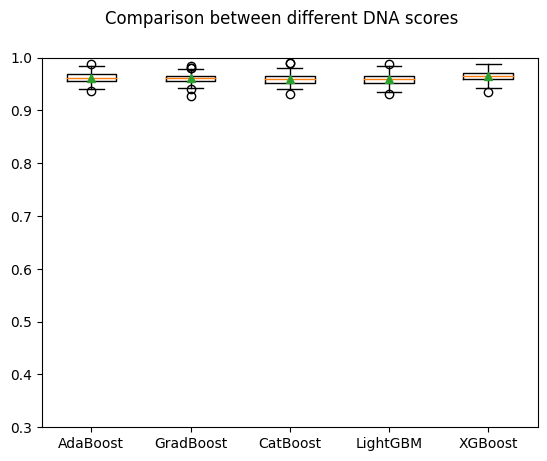

In [30]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different DNA scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(dna_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [31]:
Algo_ult_results = pd.DataFrame()
Algo_ult_results['Names'] = names

In [32]:
Algo_ult_results['DNA'] = dna_scores_mean

In [33]:
Algo_ult_results

,Names,DNA
0,AdaBoost,96.224256
1,GradBoost,96.079878
2,CatBoost,95.991808
3,LightGBM,95.954289
4,XGBoost,96.512943


In [49]:
Algo_ult_time_results = pd.DataFrame()
Algo_ult_time_results['Names'] = names

In [50]:
Algo_ult_time_results['Wine'] = pd.Series(execution_times)

In [51]:
Algo_ult_time_results

,Names,Wine
0,AdaBoost,877.854318
1,GradBoost,2370.683348
2,CatBoost,584.760997
3,LightGBM,13.880130
4,XGBoost,490.302212


---

# **Tic-Tac-Toe Dataset**

---

In [46]:
tictactoe_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\TicTacToe\TicTacToe.data', header=None)

In [47]:
tictactoe_df.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [ ]:
# dummies = {
#             'x': 0,
#             'o': 1,
#             'b': 2,
#           }
# tictactoe_df = tictactoe_df.iloc[:, 0: 9].replace(dummies)

In [ ]:
X = tictactoe_df.iloc[:, :-1]
y = tictactoe_df.iloc[:, -1]

In [ ]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [01:08<00:00,  1.38s/trial, best loss: -0.8125]            
Best hyperparameters for AdaBoost:
{'n_estimators': 1200.0, 'learning_rate': 0.06916005440000361, 'max_depth': 2.0, 'max_features': None, 'min_samples_leaf': 4.0, 'min_samples_split': 4.0, 'random_state': 42}
100%|██████████| 50/50 [01:11<00:00,  1.43s/trial, best loss: -0.8177083333333334]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': None, 'n_estimators': 850, 'learning_rate': 0.09835742587463962, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 0.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [00:37<00:00,  1.34trial/s, best loss: -0.71875]           
Best hyperparameters for CatBoost:
{'n_estimators': 1350, 'learning_rate': 0.052871577465477125, 'min_child_samples': 9, 'max_depth': 1, 'reg_lambda': 3.1381917920726017, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [ ]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [ ]:
tictactoe_scores = []
tictactoe_mean = []
tictactoe_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)

    start_time = time.time()    
    results = cross_val_score(clf, X, y, cv=rskf)
    end_time = time.time()
    tictactoe_scores.append(results)
    tictactoe_mean.append(results.mean()*100)
    tictactoe_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)
    print(f'--------- {algorithm_name} on TicTacToe Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on TicTacToe Dataset ---------
[0.875      0.88541667 0.77083333 0.82291667 0.875      0.73958333
 0.84375    0.79166667 0.84210526 0.78947368 0.79166667 0.8125
 0.76041667 0.84375    0.78125    0.8125     0.8125     0.85416667
 0.78947368 0.82105263 0.83333333 0.78125    0.75       0.85416667
 0.90625    0.80208333 0.89583333 0.79166667 0.83157895 0.8
 0.80208333 0.84375    0.85416667 0.84375    0.76041667 0.77083333
 0.79166667 0.77083333 0.87368421 0.77894737 0.80208333 0.79166667
 0.76041667 0.73958333 0.75       0.78125    0.875      0.83333333
 0.83157895 0.86315789 0.80208333 0.80208333 0.80208333 0.80208333
 0.8125     0.80208333 0.82291667 0.82291667 0.78947368 0.81052632
 0.85416667 0.80208333 0.83333333 0.75       0.80208333 0.88541667
 0.77083333 0.78125    0.78947368 0.78947368 0.80208333 0.80208333
 0.73958333 0.79166667 0.85416667 0.84375    0.84375    0.75
 0.8        0.85263158 0.72916667 0.84375    0.79166667 0.84375
 0.8125     0.92708333 0.8229166

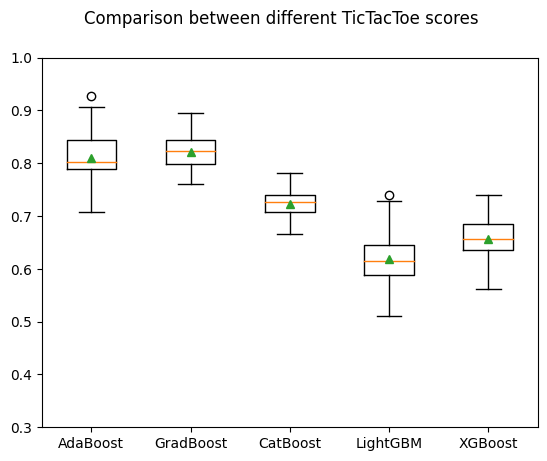

In [ ]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different TicTacToe scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(tictactoe_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [ ]:
Algo_ult_results['TicTacToe'] = tictactoe_mean

In [ ]:
Algo_ult_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,TicTacToe
0,AdaBoost,96.552288,97.159847,86.347619,93.815873,81.054167
1,GradBoost,98.075163,96.646633,78.145238,90.854762,82.224232
2,CatBoost,97.967320,97.378303,87.076190,93.815079,72.318311
3,LightGBM,97.120915,97.334612,82.361905,92.849206,61.814474
4,XGBoost,97.797386,96.792626,83.802381,92.960317,65.721053


In [ ]:
Algo_ult_time_results['TicTacToe'] = pd.Series(execution_times)

# **Moon Dataset (Data with Irregular Boundaries)**

In [84]:
from sklearn.datasets import make_moons
moons_df = make_moons(n_samples=5000, shuffle=True, noise=0.2, random_state=42)


In [85]:
X = moons_df[0]
y = moons_df[1]

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [03:47<00:00,  4.55s/trial, best loss: -0.972]
Best hyperparameters for AdaBoost:
{'n_estimators': 450.0, 'learning_rate': 0.01199453123793802, 'max_depth': 4.0, 'max_features': 'log2', 'min_samples_leaf': 4.0, 'min_samples_split': 6.0, 'random_state': 42}
100%|██████████| 50/50 [02:18<00:00,  2.77s/trial, best loss: -0.97] 
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': None, 'n_estimators': 850, 'learning_rate': 0.053611707225416305, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 0.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [01:11<00:00,  1.43s/trial, best loss: -0.972]
Best hyperparameters for CatBoost:
{'n_estimators': 100, 'learning_rate': 0.055410579441262556, 'min_child_samples': 6, 'max_depth': 3, 'reg_lambda': 2.9581987876632354, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 [00:02<00:00, 20.57trial/s, best loss

In [88]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [89]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [90]:
moon_scores = []
moon_mean = []
moon_std = []
model_names = []
execution_times = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)

    start_time = time.time()    
    results = cross_val_score(clf, X, y, cv=rskf)
    end_time = time.time()
    moon_scores.append(results)
    moon_mean.append(results.mean()*100)
    moon_std.append(results.std()*100)
    model_names.append(algorithm_name)
    execution_time = end_time - start_time  
    execution_times.append(execution_time)
    print(f'--------- {algorithm_name} on Moon Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print(f'Execution Time: {execution_time:.2f} seconds')
    print('------------------------------')

--------- AdaBoost on Moon Dataset ---------
[0.964 0.964 0.97  0.964 0.97  0.974 0.974 0.972 0.962 0.97  0.974 0.97
 0.966 0.966 0.976 0.962 0.976 0.954 0.97  0.964 0.97  0.968 0.962 0.974
 0.976 0.972 0.968 0.976 0.966 0.966 0.952 0.96  0.976 0.966 0.98  0.98
 0.97  0.982 0.952 0.974 0.972 0.964 0.958 0.958 0.978 0.98  0.972 0.976
 0.976 0.982 0.968 0.974 0.97  0.974 0.964 0.964 0.978 0.956 0.97  0.976
 0.966 0.968 0.968 0.984 0.958 0.978 0.978 0.962 0.97  0.978 0.97  0.966
 0.97  0.968 0.978 0.964 0.97  0.974 0.962 0.976 0.984 0.966 0.962 0.96
 0.964 0.974 0.97  0.968 0.972 0.96  0.98  0.966 0.976 0.966 0.964 0.962
 0.974 0.974 0.968 0.968]
Accuracy: 96.95% (0.69%)
Execution Time: 304.63 seconds
------------------------------
--------- GradBoost on Moon Dataset ---------
[0.966 0.966 0.976 0.962 0.966 0.968 0.972 0.978 0.97  0.97  0.97  0.976
 0.97  0.972 0.98  0.964 0.972 0.96  0.97  0.966 0.97  0.968 0.958 0.976
 0.976 0.976 0.978 0.976 0.966 0.966 0.964 0.96  0.972 0.962 0.972 0.

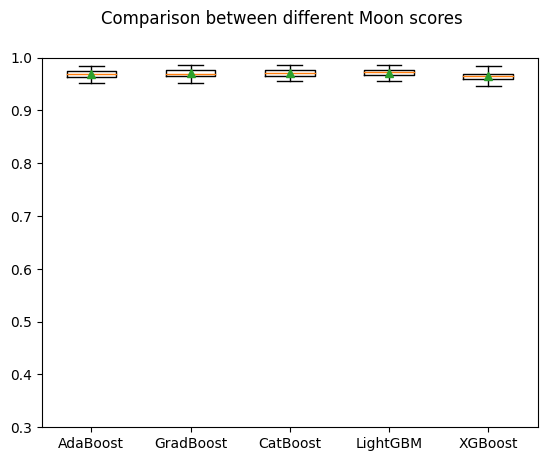

In [91]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Moon scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(moon_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [92]:
Algo_ult_results['Moon'] = moon_mean

In [93]:
Algo_ult_results

,Names,DNA,Moon
0,AdaBoost,96.224256,96.948
1,GradBoost,96.079878,97.024
2,CatBoost,95.991808,97.062
3,LightGBM,95.954289,97.160
4,XGBoost,96.512943,96.508


In [94]:
Algo_ult_time_results['Moon'] = pd.Series(execution_times)

In [95]:
Algo_ult_time_results

,Names,Wine,Moon
0,AdaBoost,877.854318,304.634132
1,GradBoost,2370.683348,572.574119
2,CatBoost,584.760997,19.937263
3,LightGBM,13.880130,4.116436
4,XGBoost,490.302212,10.219701
